# DFE Inference
## Base inference
In order to infer the DFE of a single pair, one neutral and one selected, we can use {class}`~fastdfe.base_inference.BaseInference`. In this example we create {class}`~fastdfe.spectrum.Spectrum` objects holding the SFS counts and pass it to BaseInference. Note that we are required to specify the number of monomorphic sites (the first entry).

In [1]:
from fastdfe import BaseInference, Spectrum

sfs_neut = Spectrum([177130, 997, 441, 228, 156, 117, 114, 83, 105, 109, 652])
sfs_sel = Spectrum([797939, 1329, 499, 265, 162, 104, 117, 90, 94, 119, 794])

# create inference object
inf = BaseInference(
    sfs_neut=sfs_neut,
    sfs_sel=sfs_sel
)

# run inference
inf.run();

INFO:fastdfe:Starting numerical optimization of 10 independently initialized samples which are run in parallel.
INFO:fastdfe:Precomputing linear DFE-SFS transformation using midpoint integration.
INFO:fastdfe:Successfully finished optimization after 34 iterations and 252 function evaluations, obtaining a log-likelihood of -34.719718789150534.
INFO:fastdfe:Inferred parameters: {'all.S_d': -2586.3539552883835, 'all.b': 0.25939981739231877, 'all.p_b': 0.11535210445006201, 'all.S_b': 0.0001, 'all.eps': 0.00589010030036535}.



fastDFE uses maximum likelihood estimation (MLE) to find the DFE. By default, 10 local optimization runs are carried out to make sure a reasonably good global optimum has been bound (see {class}`~fastdfe.base_inference.BaseInference` for all configuration options). The DFE furthermore needs to parametrized where {class}`~fastdfe.parametrization.GammaExpParametrization` is used by default.

We can now plot the inferred DFE in discretized form (cf. {func}`~fastdfe.base_inference.BaseInference.plot_discretized`).

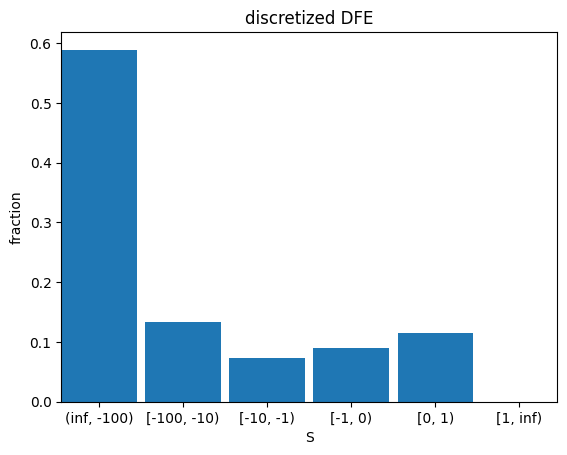

In [2]:
inf.plot_discretized();

We can also plot a comparison of the (selected) modelled and observed SFS (cf. {func}`~fastdfe.base_inference.BaseInference.plot_sfs_comparison`).

<Figure size 640x480 with 0 Axes>

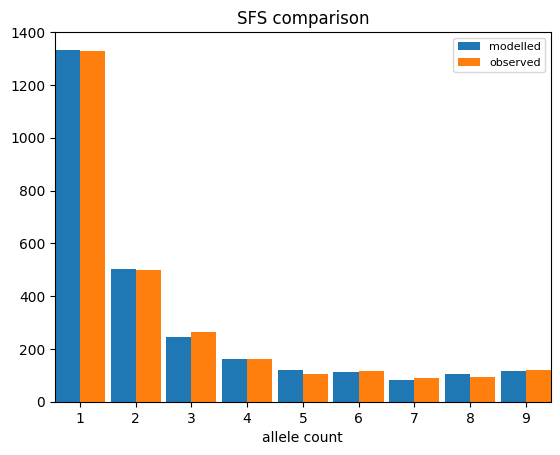

In [3]:
inf.plot_sfs_comparison();

### Bootstrapping

We can perform parametric bootstrapping (cf. {func}`~fastdfe.base_inference.BaseInference.bootstrap`) to estimate the uncertainty of the inferred DFE. This is done by sampling new SFSs from the inferred DFE and re-running the inference.

INFO:fastdfe:Running 100 bootstrap samples in parallel on 10 cores.


100%|██████████| 100/100 [00:01<00:00, 75.50it/s]


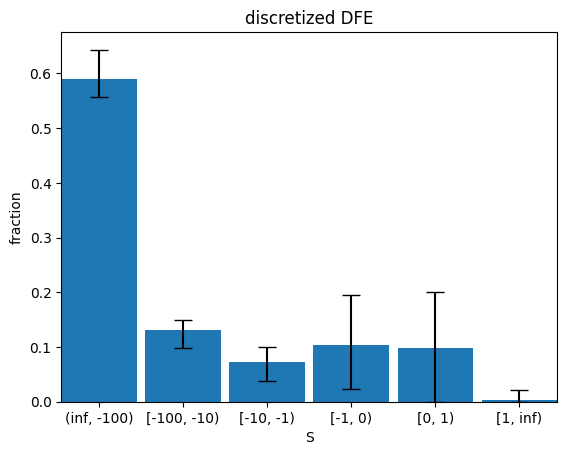

In [4]:
# run bootstrapping
inf.bootstrap(n_samples=100)

# redo the plotting
inf.plot_discretized();

The bars indicate 95% confidence intervals. We can adjust the confidence level among other things (cf. {func}`~fastdfe.base_inference.BaseInference.plot_discretized`).

### Fixing parameters
We can hold parameters fixed during the maximum likelihood optimization. This is useful, for example, if only using a subset of the parameters has a reasonable interpretation. In this example, we fix ancestral-allele mis-identification rate ``eps`` to 0. We also force the DFE to be purely deleterious, by fixing ``S_b`` to some arbitrary value and setting ``p_b`` to 0 (cf. {class}`~fastdfe.parametrization.GammaExpParametrization`).

INFO:fastdfe:Starting numerical optimization of 10 independently initialized samples which are run in parallel.
INFO:fastdfe:Precomputing linear DFE-SFS transformation using midpoint integration.
INFO:fastdfe:Successfully finished optimization after 49 iterations and 249 function evaluations, obtaining a log-likelihood of -35.5928911918121.
INFO:fastdfe:Inferred parameters: {'all.S_d': -15899.609858769645, 'all.b': 0.14201985977072357, 'all.p_b': 0.0, 'all.S_b': 1.0, 'all.eps': 0.0}.


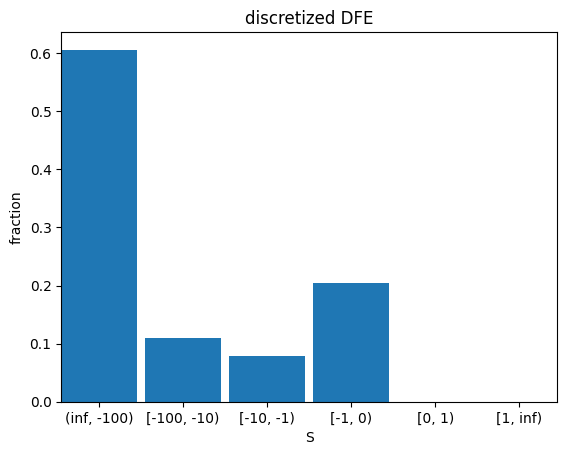

In [5]:
# create inference object
inf = BaseInference(
    sfs_neut=sfs_neut,
    sfs_sel=sfs_sel,
    # Fix parameters, note that we need to use
    # type 'all' if only one type is used.
    fixed_params=dict(all=dict(eps=0, S_b=1, p_b=0))
)

# run inference
inf.run()

inf.plot_discretized();

### Nested model comparison
We can automatically check for the significance of include ancestral-allele mis-idenfication and beneficial fitness affects using likelihood ratio test (LRTs). This is done with {func}`~fastdfe.base_inference.BaseInference.plot_nested_likelihoods`. The LRTs are performed by comparing the likelihood of the inferred DFE to the likelihood of a nested model where some parameters are held fixed.

INFO:fastdfe:Holding parameters fixed to {'all': {'eps': 0}}.
INFO:fastdfe:Starting numerical optimization of 10 independently initialized samples which are run in parallel.
INFO:fastdfe:Successfully finished optimization after 40 iterations and 400 function evaluations, obtaining a log-likelihood of -35.054181364454905.
INFO:fastdfe:Inferred parameters: {'all.S_d': -3548.9173499186445, 'all.b': 0.20814120412844353, 'all.p_b': 0.05583478056236137, 'all.S_b': 1.0949192867028816, 'all.eps': 0.0}.
INFO:fastdfe:Holding parameters fixed to {'all': {}}.
INFO:fastdfe:Starting numerical optimization of 10 independently initialized samples which are run in parallel.
INFO:fastdfe:Successfully finished optimization after 51 iterations and 438 function evaluations, obtaining a log-likelihood of -34.63824907148995.
INFO:fastdfe:Inferred parameters: {'all.S_d': -8135.5264093927535, 'all.b': 0.16020045109703812, 'all.p_b': 0.014332645095904546, 'all.S_b': 0.0001, 'all.eps': 0.006912630503687684}.
INF

<Figure size 640x480 with 0 Axes>

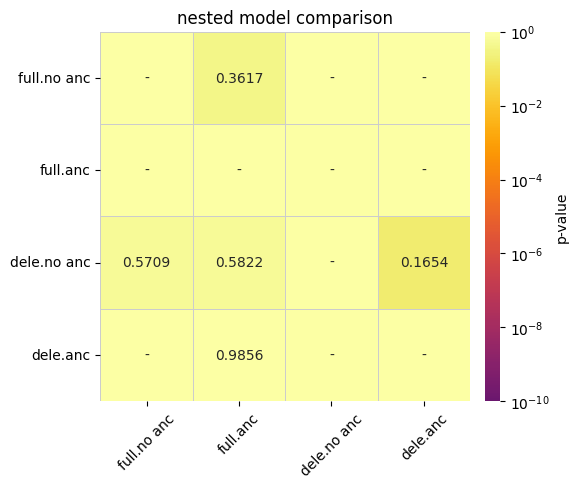

In [6]:
inf.plot_nested_likelihoods();

The full DFE appears to explain the data significantly better than the deleterious DFE. However, including ancestral-allele mis-identification does not appear to be significant.

### Visualize likelihoods
We can visualize the likelihoods of the differently-initialized optimization runs. This can give us some information on how good an optimum could be found.

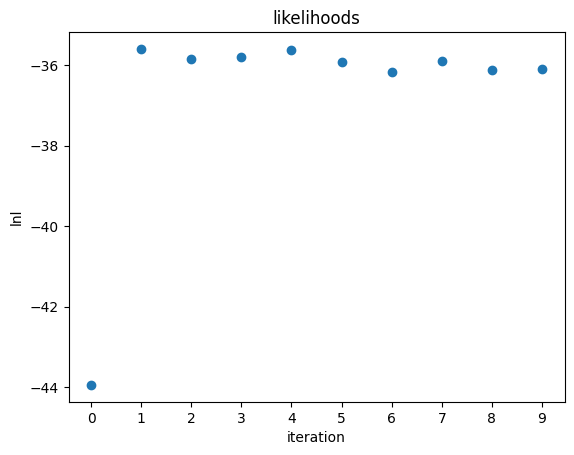

In [7]:
inf.plot_likelihoods(scale='lin');

There might be some room for improvement as the likelihoods do show some variation. We could consider increasing the ``n_runs`` argument.

### Serialization

In [8]:
# save the inference object to the file
# we can unserialized the inference by using BaseInference.from_file
inf.to_file("out/serialized.json")

# we can also save a summary to file
inf.get_summary().to_file("out/summary.json")


## Shared inference
fastDFE supports joint inference of several SFS types, where any parameters can be shared between types. In this example, we create a {class}`~fastdfe.shared_inference.SharedInference` object with two types, where we share ``eps``, the rate of ancestral misidentification and ``S_d``, the mean selection coefficient for deleterious mutations (cf. {class}`~fastdfe.parametrization.GammaExpParametrization`). For more complex stratifications, see the {class}`~fastdfe.parser.Parser`) module.

In [9]:
import logging

import fastdfe
from fastdfe import SharedInference, Spectra, SharedParams

# disable progress bar and set logging level to warning  to avoid cluttering
fastdfe.disable_pbar = True
logging.getLogger('fastdfe').setLevel(logging.WARNING)

# neutral SFS for two types
sfs_neut = Spectra(dict(
    pendula=[177130, 997, 441, 228, 156, 117, 114, 83, 105, 109, 652],
    pubescens=[172528, 3612, 1359, 790, 584, 427, 325, 234, 166, 76, 31]
))

# selected SFS for two types
sfs_sel = Spectra(dict(
    pendula=[797939, 1329, 499, 265, 162, 104, 117, 90, 94, 119, 794],
    pubescens=[791106, 5326, 1741, 1005, 756, 546, 416, 294, 177, 104, 41]
))

# create inference object
inf = SharedInference(
    sfs_neut=sfs_neut,
    sfs_sel=sfs_sel,
    shared_params=[SharedParams(types=["pendula", "pubescens"], params=["eps", "S_d"])],
    do_bootstrap=True
)

# run inference
inf.run();

{class}`~fastdfe.shared_inference.SharedInference` both runs the joint inference and marginal inference where each type is inferred separately. To see this better we can plot the inferred parameters for the different inference types.

<Figure size 640x480 with 0 Axes>

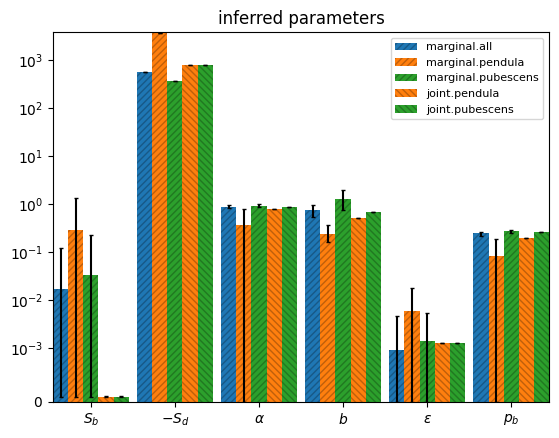

In [10]:
inf.plot_inferred_parameters();

``marginal.pendula`` and ``marginal.pubescens`` are the marginal inferences for the respective type. ``marginal.all`` is the marginal inference obtaining by adding up the spectra of all types. ``joint.pendula`` and ``join.pubescens`` are the joint inferences for the respective type. We can see that ``eps`` and ``S_d`` are indeed shared between the two. The parameter ``alpha`` in the plot denotes the proportion of beneficial non-synonymous substitutions. Each marginal inference is a {class}`~fastdfe.base_inference.BaseInference` object itself and can be accessed via ``inf.marginal_inferences[type]``.

Looking at the discretized DFE we can see the different between the inference types:

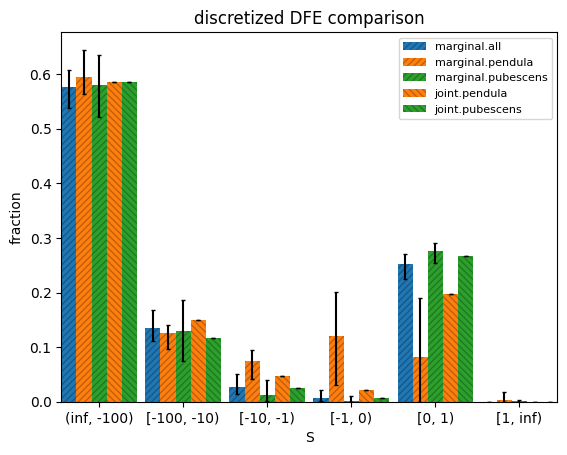

In [11]:
inf.plot_discretized();

### Model comparison
We can obtain information about the goodness of fit achieved by sharing the parameter by performing a likelihood ratio test (cf. {func}`~fastdfe.shared_inference.SharedInference.perform_lrt_shared`). This compares the likelihood of the joint inference with the product of the marginal likelihoods.

In [12]:
inf.perform_lrt_shared()

0.5262104318851502

The test is not significant, indicating that the simpler model of sharing the parameters explains the data sufficiently well. Indeed, we do not observe a lot of differences between the inferred parameters of the marginal inferences.

## Covariates
{class}`~fastdfe.shared_inference.SharedInference` also supports the inclusion of covariates associates with the different SFS types. This provides more powerful model testing and reduces the number of parameters that need to be estimated for the joint inference. For a more interesting example we stratify the SFS of `B. pendula` by the sites' reference base as is described in more detail in the {mod}`~fastdfe.parser` module.

<Figure size 640x480 with 0 Axes>

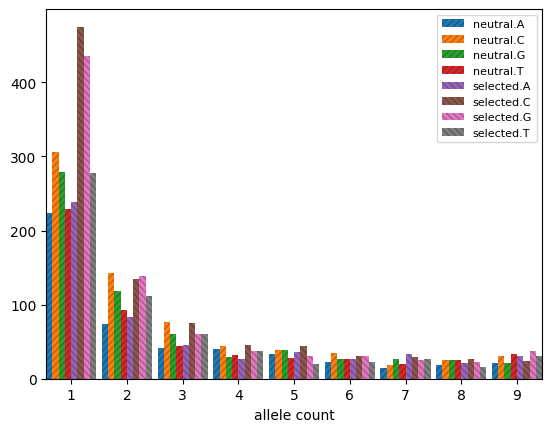

In [13]:
from fastdfe import Parser, Spectra, ReferenceBaseStratification, DegeneracyStratification

# instantiate parser
p = Parser(
    n=10,
    vcf_file="../../snakemake/results/vcf/betula/pendula.vcf.gz",
    stratifications=[DegeneracyStratification(), ReferenceBaseStratification()]
)

# parse SFS
spectra: Spectra = p.parse()

# visualize spectra
spectra.plot();

We now create the inference object from the spectra. In this contrived example we make up some covariates that covary with ``S_d``, the mean strength of negative selection. Covariates introduce a linear relationship by default but this can be modified by specifying a custom callback function (cf. {class}`~fastdfe.optimization.Covariate`).

In [14]:
from fastdfe import Covariate

# create inference object
inf = SharedInference(
    sfs_neut=spectra[['neutral.*']].merge_groups(1),
    sfs_sel=spectra[['selected.*']].merge_groups(1),
    covariates=[Covariate(param='S_d', values=dict(A=1, C=2, T=3, G=4))],
    do_bootstrap=True
)

# run inference
inf.run();

Let's visualize the covariates

<Figure size 640x480 with 0 Axes>

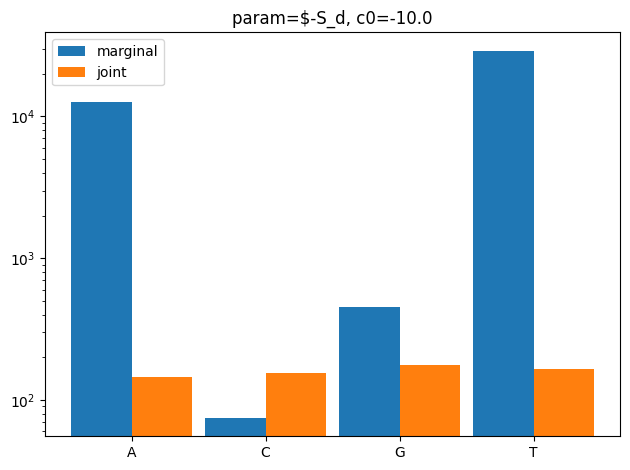

In [15]:
inf.plot_covariates();

### Model comparison
Covariates receive the parameter names ``c{i}`` in order of definition. We do see that ``S_b`` indeed varies among the types and this is due to the linear relationship with the covariate values introduced. We can perform a likelihood ratio test to see whether including the covariates produce a significantly better fit than simply sharing the parameter in question among the types (cf. {func}`~fastdfe.shared_inference.SharedInference.perform_lrt_covariates`).

In [16]:
inf.perform_lrt_covariates()

0.8073729452826015